<a href="https://colab.research.google.com/github/LiangzeCui/ACGAN-FinalProject-Pytorch/blob/main/ACGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount("/content/drive")
import os
path="/content/drive/My Drive/Colab Notebooks/ECE661_2021F_FinalProject/pytorch_ACGAN/"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['images',
 'data',
 'images600',
 'images200',
 'models.py',
 'images100',
 '__pycache__',
 'imageTest',
 'images300',
 'G_standard.pt',
 'D_standard.pt']

In [2]:
import torch
from torch import nn
import torch.utils.data
import torchvision.datasets as data_set
import torchvision.transforms as transforms
# Custom
import models
from models import generator,discriminator
from torch import optim
from torch.autograd import Variable
import numpy as np
import torchvision.utils as vutils
lr=0.0002
epochs=300
batch_size=100
real_label = torch.FloatTensor(batch_size).cuda()
real_label.fill_(1)
real_label=real_label.unsqueeze(1)

fake_label = torch.FloatTensor(batch_size).cuda()
fake_label.fill_(0)
fake_label=fake_label.unsqueeze(1)

eval_noise = torch.FloatTensor(batch_size, 110, 1, 1).normal_(0, 1)
eval_noise_ = np.random.normal(0, 1, (batch_size, 110))
eval_label = np.random.randint(0, 10, batch_size)
eval_onehot = np.zeros((batch_size, 10))
eval_onehot[np.arange(batch_size), eval_label] = 1
eval_noise_[np.arange(batch_size), :10] = eval_onehot[np.arange(batch_size)]
eval_noise_ = (torch.from_numpy(eval_noise_))
eval_noise.data.copy_(eval_noise_.view(batch_size, 110, 1, 1))
eval_noise=eval_noise.cuda()


def compute_acc(preds, labels):
	correct = 0
	preds_ = preds.data.max(1)[1]
	correct = preds_.eq(labels.data).cpu().sum()
	acc = float(correct) / float(len(labels.data)) * 100.0
	return acc

def weights_init(m):
		classname = m.__class__.__name__
		if classname.find('Conv') != -1:
			m.weight.data.normal_(0.0, 0.02)
		elif classname.find('BatchNorm') != -1:
			m.weight.data.normal_(1.0, 0.02)
			m.bias.data.fill_(0)

dataset = data_set.CIFAR10(
				root='data/', download=True,
				transform=transforms.Compose([
					transforms.Scale((32,32)),
					transforms.ToTensor(),
					transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
					]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
gen=generator(110).cuda()
disc=discriminator().cuda()
## Checkpoint name for this model
model_checkpoint_G = "G_standard.pt"
model_checkpoint_D = "D_standard.pt"

gen.apply(weights_init)

optimD=optim.Adam(disc.parameters(),lr)
optimG=optim.Adam(gen.parameters(),lr)

source_obj=nn.BCELoss()#source-loss

class_obj=nn.NLLLoss()#class-loss


for epoch in range(epochs):
	for i,data in enumerate(dataloader,0):
		'''
		At first we will train the discriminator
		'''
		#training with real data----
		optimD.zero_grad()

		image,label=data
		image,label=image.cuda(),label.cuda()
		
		source_,class_=disc(image)#we feed the real images into the discriminator
		# print(source_.size())
		# print(real_label.size())
		# real_label=real_label.unsqueeze(1)
		source_error=source_obj(source_,real_label)#label for real images--1; for fake images--0
		class_error=class_obj(class_,label)
		error_real=source_error+class_error
		error_real.backward()
		optimD.step()


		accuracy=compute_acc(class_,label)#getting the current classification accuracy

		#training with fake data now----

		
		noise_ = np.random.normal(0, 1, (batch_size, 110))#generating noise by random sampling from a normal distribution
		
		label=np.random.randint(0,10,batch_size)#generating labels for the entire batch
		
		noise=((torch.from_numpy(noise_)).float())
		noise=noise.cuda()#converting to tensors in order to work with pytorch

		label=((torch.from_numpy(label)).long())
		label=label.cuda()#converting to tensors in order to work with pytorch
		
		noise_image=gen(noise)
		#print(noise_image.size())

		source_,class_=disc(noise_image.detach())#we will be using this tensor later on
		#print(source_.size())
		# fake_label=fake_label.unsqueeze(1)
		source_error=source_obj(source_,fake_label)#label for real images--1; for fake images--0
		class_error=class_obj(class_,label)
		error_fake=source_error+class_error
		error_fake.backward()
		optimD.step()


		'''
		Now we train the generator as we have finished updating weights of the discriminator
		'''

		gen.zero_grad()
		source_,class_=disc(noise_image)
		source_error=source_obj(source_,real_label)#The generator tries to pass its images as real---so we pass the images as real to the cost function
		class_error=class_obj(class_,label)
		error_gen=source_error+class_error
		error_gen.backward()
		optimG.step()
		iteration_now = epoch * len(dataloader) + i


		# print("Epoch--[{} / {}], Loss_Discriminator--[{}], Loss_Generator--[{}],Accuracy--[{}]".format(epoch,epochs,error_fake,error_gen,accuracy))


		# '''Saving the images by the epochs'''
		if i % epochs == 0:
			constructed = gen(eval_noise)*0.5+0.5
			vutils.save_image(
				constructed.data,
				'%s/results_epoch_%03d.png' % ('images300/', epoch)
				)
	print("Epoch--[{} / {}], Loss_Discriminator--[{}], Loss_Generator--[{}],Accuracy--[{}]".format(epoch,epochs,error_fake,error_gen,accuracy))	 
  # Save model
	torch.save(gen.state_dict(), model_checkpoint_G)
	torch.save(disc.state_dict(), model_checkpoint_D) 	    

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Files already downloaded and verified


/content/drive/My Drive/Colab Notebooks/ECE661_2021F_FinalProject/pytorch_ACGAN/models.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c=self.soft(self.fc_class(x))#checks class(label) of data--i.e. to which label the data belongs in the CIFAR10 dataset


Epoch--[0 / 300], Loss_Discriminator--[0.4153839349746704], Loss_Generator--[2.5544722080230713],Accuracy--[25.0]
Epoch--[1 / 300], Loss_Discriminator--[0.09134463220834732], Loss_Generator--[4.259140491485596],Accuracy--[26.0]
Epoch--[2 / 300], Loss_Discriminator--[-0.016925007104873657], Loss_Generator--[7.76172399520874],Accuracy--[30.0]
Epoch--[3 / 300], Loss_Discriminator--[-0.07744892686605453], Loss_Generator--[4.246716022491455],Accuracy--[32.0]
Epoch--[4 / 300], Loss_Discriminator--[-0.11853935569524765], Loss_Generator--[6.607958793640137],Accuracy--[30.0]
Epoch--[5 / 300], Loss_Discriminator--[-0.07546484470367432], Loss_Generator--[6.495851993560791],Accuracy--[33.0]
Epoch--[6 / 300], Loss_Discriminator--[-0.014632143080234528], Loss_Generator--[5.6117401123046875],Accuracy--[32.0]
Epoch--[7 / 300], Loss_Discriminator--[-0.06855908036231995], Loss_Generator--[4.930546283721924],Accuracy--[28.999999999999996]
Epoch--[8 / 300], Loss_Discriminator--[-0.07090941071510315], Loss

In [4]:
##Skip the training process#

import torch
from torch import nn
import torch.utils.data
import torchvision.datasets as data_set
import torchvision.transforms as transforms
# Custom
import models
from models import generator,discriminator
from torch import optim
from torch.autograd import Variable
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt


lr=0.0002
epochs=100
batch_size=100
real_label = torch.FloatTensor(batch_size).cuda()
real_label.fill_(1)
real_label=real_label.unsqueeze(1)

fake_label = torch.FloatTensor(batch_size).cuda()
fake_label.fill_(0)
fake_label=fake_label.unsqueeze(1)

eval_noise = torch.FloatTensor(batch_size, 110, 1, 1).normal_(0, 1)
eval_noise_ = np.random.normal(0, 1, (batch_size, 110))
eval_label = np.random.randint(0, 10, batch_size)
eval_onehot = np.zeros((batch_size, 10))
eval_onehot[np.arange(batch_size), eval_label] = 1
eval_noise_[np.arange(batch_size), :10] = eval_onehot[np.arange(batch_size)]
eval_noise_ = (torch.from_numpy(eval_noise_))
eval_noise.data.copy_(eval_noise_.view(batch_size, 110, 1, 1))
eval_noise=eval_noise.cuda()

print(eval_noise.shape)

def compute_acc(preds, labels):
	correct = 0
	preds_ = preds.data.max(1)[1]
	correct = preds_.eq(labels.data).cpu().sum()
	acc = float(correct) / float(len(labels.data)) * 100.0
	return acc

def weights_init(m):
		classname = m.__class__.__name__
		if classname.find('Conv') != -1:
			m.weight.data.normal_(0.0, 0.02)
		elif classname.find('BatchNorm') != -1:
			m.weight.data.normal_(1.0, 0.02)
			m.bias.data.fill_(0)

dataset = data_set.CIFAR10(
				root='data/', download=True,
				transform=transforms.Compose([
					transforms.Scale((32,32)),
					transforms.ToTensor(),
					transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
					]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)



torch.Size([100, 110, 1, 1])


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Files already downloaded and verified


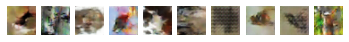

In [20]:
# create a plot of generated images
def plot_generated(examples, m, n):
	# plot images
  for i in range(m):
    for j in range(n):
		# define subplot
      pyplot.subplot(m,n , 1 + i*n+j)
		  # turn off axis
      pyplot.axis('off')
		  # plot raw pixel data
      pyplot.imshow(examples[ :, :, :, i*n+j])
  pyplot.show()


##Generate a specific class samples

net_generator = models.generator(110).cuda()
net_generator.load_state_dict(torch.load("G_standard.pt"))


eval_noise = torch.FloatTensor(batch_size, 110, 1, 1).normal_(0, 1)
eval_noise_ = np.random.normal(0, 1, (batch_size, 110))
eval_label = np.ones(batch_size, dtype=int)*9 #class label
eval_onehot = np.zeros((batch_size, 10))
eval_onehot[np.arange(batch_size), eval_label] = 1
eval_noise_[np.arange(batch_size), :10] = eval_onehot[np.arange(batch_size)]
eval_noise_ = (torch.from_numpy(eval_noise_))
eval_noise.data.copy_(eval_noise_.view(batch_size, 110, 1, 1))
eval_noise=eval_noise.cuda()



constructed = net_generator(eval_noise)

# print(constructed.data.shape)

plt.figure()
# plt.imshow(constructed.data)
figureShow=constructed.cpu().detach().numpy()
figureShow=figureShow*0.5+0.5
# plt.imshow(figureShow[30,:,:,:].T)
# plt.title("Fake Images")
# plt.show()
plot_generated(figureShow.T,1,10)


In [6]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

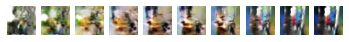

In [8]:
# example of interpolating between generated images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n):
		# define subplot
		pyplot.subplot(1, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[ :, :, :, i])
	pyplot.show()

# load model
net_generator = models.generator(110).cuda()
net_generator.load_state_dict(torch.load("G_standard.pt"))

# generate points in latent space
# pts = generate_latent_points(100, 2)
pts = generate_latent_points(110, 100)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
constructed = net_generator(torch.Tensor(interpolated).cuda())
figureShow=constructed.cpu().detach().numpy()
# figureShow=figureShow*0.5+0.5
X = figureShow[:,:,:,:].T
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))